In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.cluster import KMeans
from kneed import KneeLocator

Для диверсификации рекламы и коммуникацации с потенциальными клиентами требуется сегментирование (кластеризация) существующей базы. Для кластеризации используем метод k-средних, так как он отличается высокой скоростью и простотой реализации.

Датасет содержит действия пользователей (cookie) на сайтах клиента. Данные включают в себя:
* уникальный идентификатор события (поле event_ id)
* дату и время события (поле date)
* уникальный ID пользователя (поле cookie_id)
* уникальный идентификатор сессии, в рамках которой произошло событие (поле session_id)
* сайт, на котором произошло событие (поле domain_id)
* тип события (поле event_ type)


Загружаем датасет. Для экономии памяти заранее отбрасываем ненужные колонки.

In [2]:
df = pd.read_csv('data.csv', dtype=str, usecols=['date', 'cookie_id', 'domain_id'], parse_dates=['date'])

In [3]:
df.head()

,date,cookie_id,domain_id
0,2020-08-18 00:00:01.065710,9e2c1cf7-83a4-4fcf-9d87-63e316a0c91f,a1fb2d2a-9c3e-49e2-a651-cf52fbf0212a
1,2020-08-18 00:00:01.066429,9e2c1cf7-83a4-4fcf-9d87-63e316a0c91f,a1fb2d2a-9c3e-49e2-a651-cf52fbf0212a
2,2020-08-18 00:00:02.582822,9e2c1cf7-83a4-4fcf-9d87-63e316a0c91f,a1fb2d2a-9c3e-49e2-a651-cf52fbf0212a
3,2020-08-18 00:00:02.582836,9e2c1cf7-83a4-4fcf-9d87-63e316a0c91f,a1fb2d2a-9c3e-49e2-a651-cf52fbf0212a
4,2020-08-18 00:00:03.225834,b82ab5d5-228b-4f41-89c4-4eb74bfb4653,34308d56-1149-42a1-a0d9-5652c915ac9e


Проверяем, нет ли пропусков в датафрейме:

In [4]:
df.isnull().sum(axis=0)

date         0
cookie_id    0
domain_id    0
dtype: int64

Результаты кластеризации очень сильно зависят от времени, по которому она проводится, поэтому обращаем внимание, на временной интервал датасета. Длинные промежутки времени позволяют выявить стабильные закономерности, а короткие -- локальные закономерности, которые может быть не видно на длительном промежутке времени.

In [5]:
df['date'].max(), df['date'].min()

(Timestamp('2020-09-08 23:59:54.218274'),
 Timestamp('2020-08-18 00:00:01.065710'))

Необходимо сформировать сводную таблицу, которая будет использоваться в качестве исходных данных. Индексами строк будут значения колонки `cookie_id`, а столбцами -- `domain_id`. Также добавим датафрейму дополнительную колонку `values`, все значения в которой будут равны 1.

In [6]:
df['values'] = 1

Пропуски в таблице заполним пренебрежимо малыми величинами (но не нулями, чтобы в дальнейшем можно было провести логарифмирование значений).

In [7]:
pivot_table = df.pivot_table(index='cookie_id', columns='domain_id', values='values', aggfunc=np.sum).fillna(0.00001)

Для удобства обозначим пользователей в сводной таблице цифрами, а сайты -- буквами.

In [8]:
pd.unique(df['domain_id']).shape[0]

9

In [9]:
pivot_table.index = range(1, pivot_table.shape[0] + 1)
pivot_table.columns = list('ABCDEFGHI')
pivot_table.head()

,A,B,C,D,E,F,G,H,I
1,0.00001,7.00000,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
2,4.00000,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
3,0.00001,0.00001,0.00001,0.00001,0.00001,14.00000,0.00001,0.00001,0.00001
4,0.00001,0.00001,0.00001,0.00001,0.00001,5.00000,0.00001,0.00001,0.00001
5,0.00001,0.00001,0.00001,0.00001,0.00001,19.00000,0.00001,0.00001,0.00001


Посмотрим на то, какой диапазон значений принимают данные в сводной таблице, для этого найдём наибольшие значения:

In [10]:
pivot_table.max(axis=0)

A      1996.0
B       841.0
C      1142.0
D      1714.0
E      1123.0
F       849.0
G    674858.0
H       380.0
I       270.0
dtype: float64

Поскольку диапазон значений очень широк, применим к ним логарифмирование:

In [11]:
x_log = np.log(pivot_table)

Нормализуем данные, чтобы они принимали значения между 0 и 1:

In [12]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = pd.DataFrame(min_max_scaler.fit_transform(x_log.values))
x_scaled.columns = list('ABCDEFGHI')
x_scaled.head()

,A,B,C,D,E,F,G,H,I
0,0.000000,0.737571,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.674934,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.775154,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.718759,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.791881,0.0,0.0,0.0


Чтобы определить оптимальное число кластеров, воспользуемся методом локтя. Он подразумевает многократное циклическое исполнение алгоритма с увеличением количества выбираемых кластеров, а также последующим откладыванием на графике суммы квадратов ошибок (SSE). Оптимальное число кластеров будет находится в точке изгиба графика. Иногда бывает трудно определить её визуально, поэтому также воспользуемся модулем `kneed`, который вычисляет эту точку.

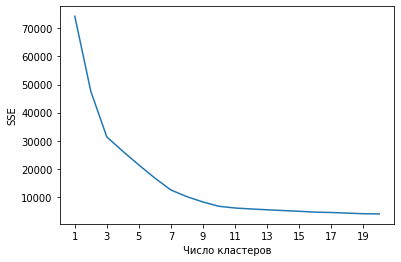

7

In [13]:
max_clusters = 20
sse = []
for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x_scaled)
    sse.append(kmeans.inertia_)
plt.plot(range(1, max_clusters + 1), sse)
plt.xticks(range(1, max_clusters + 1, 2))
plt.xlabel('Число кластеров')
plt.ylabel('SSE')
plt.show()
kl = KneeLocator(range(1,max_clusters + 1), sse, curve='convex', direction='decreasing')
kl.elbow

Проводим кластеризацию:

In [14]:
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters).fit(x_scaled)

Результатом работы алгоритма является маркировка всех пользователей в зависимости от их поведения. Клиенты с одинаковыми поведенческими характеристиками попадают в один кластер. Рассмотрим, как распределились по кластерам пользователи:

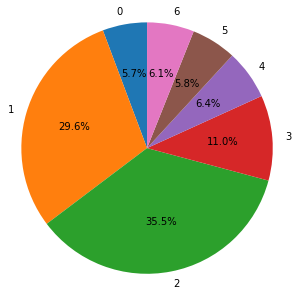

In [15]:
labels = np.arange(n_clusters)
sizes = pd.Series(kmeans.labels_).groupby(kmeans.labels_).count()

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')

plt.show()

Из круговой диаграммы видно, что две трети пользователей попали в два крупных кластера, а оставшая треть оказалась распределена между пятью кластерами.

Посмотрим, как распределились события на сайтах внутри кластеров:

In [16]:
cluster_table = pd.DataFrame(index=range(n_clusters), columns=list('ABCDEFGHI'), dtype=np.float64).fillna(0)
for i in range(n_clusters):
    cluster_table.loc[i] = x_scaled[kmeans.labels_ == i].sum(axis=0).values
cluster_table.T

,0,1,2,3,4,5,6
A,105.670568,36206.871608,2404.709487,6.497074,112.021438,259.706644,880.568666
B,12.189592,50.788528,112.029739,0.630931,98.894650,33.159665,7522.840807
C,7013.292007,63.721555,202.745498,7.280460,198.418475,18.512961,159.241802
D,24.270709,174.734845,271.820023,3.203811,136.738102,7180.292066,537.873644
E,88.550056,111.043538,252.294021,0.000000,7683.663739,66.253977,388.001869
F,121.728772,575.517252,45402.404061,11.485826,230.770298,180.651412,804.487220
G,112.311756,288.308361,654.803171,7949.431124,456.292356,147.922145,494.221713
H,24.308602,71.120780,424.787629,1459.936137,73.812506,56.237532,371.196678
I,90.236820,46.337018,174.162363,1902.955425,608.923546,45.467699,267.578387


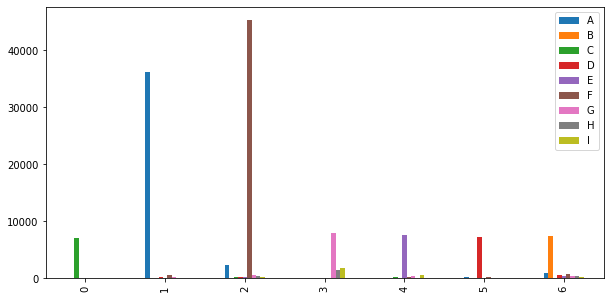

In [17]:
cluster_table.plot.bar(figsize=(10,5))
plt.show()

Из графика видно, что в каждом кластере подавляющее большинство занимают события, произошедшие на каком-либо одном сайте. После этого необходимо провести анализ каждого кластера и выявить характеристики пользователей, что позволит персонализировать подход к пользователям:
* Траффик кластера. Позволяет определить кластеры, приносящие наибольший траффик.
* Доля кластера в общем траффике в процентном соотношении за выбранный период.
* Количество пользователей в кластере.
* Количество новых пользователей в кластере. (ID пользователя появляется впервые за выбранный период кластеризации).
* Общее количество сессий в кластере.
* Количество сессий на одного клиента в кластере. Позволяет отследить сколько раз возвращался клиент за выбранный период кластеризации.
* Среднее количество действий в сессии.
* Средняя продолжительность сессии.
* Время суток, в котором производится сессия.